In [11]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
import gymnasium as gym
import random

SIZE = (210, 160, 3)
NUM_OBS = 500
NUM_EPISODES = 10
WINDOW_SIZE = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(3,8,5,bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(4,4),
            nn.Conv2d(8,32,3,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,64,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,3),2),
        )
        
    def forward(self,x):
        x=self.fc(x)
        x=x.view(-1,512)
        return x

In [15]:
class Agent:
    
    def __init__(self, model, deepMem, epsMem, batchsize=64, epsize=3, l_rate=0.001):
        self.model = model
        self.target_model = model.copy()
        self.deepMem = deepMem
        self.epsMem = epsMem
        self.batchsize = batchsize
        self.epsize = epsize
        self.epsilon = 1.0
        self.gamma = 0.9
        self.optimizer = torch.optim.Adagrad(self.model.parameters(), lr=l_rate)
        self.train_count = 0


    def process_img(self, img):
        img = img / 255.0
        img = img - 0.445 # mean
        img = img / 0.225 # std
        img = np.transpose(img, axes=(2, 0, 1))
        return img

    def parse_state(self, state):
        new_state = [self.process_img(x) for x in state]
        return new_state
    
    def make_states(self, states):
        states = [self.parse_state(s) for s in states]
        states = torch.Tensor(states).view(-1, WINDOW_SIZE, 3, 210, 160).to(device)
        return states

    def predict(self, state):
        state = self.make_states(state)
        pred = self.model(state)
        if random.random() < self.epsilon:
            return random.randint(0, 7)
        else:
            return torch.argmax(pred[0]).item()

    def train(self):
        deep_batch = self.deepMem.sample(self.batchsize)
        eps_batch = self.epsMem.sample(self.epsize)
        batch = deep_batch + eps_batch
        
        states = [x[0] for x in batch]
        next_states = [x[1] for x in batch]
        actions = [x[2] for x in batch]
        rewards = [x[3] for x in batch]
        dones = [int(x[4]) for x in batch]
        
        states = self.make_batch(states)
        next_states = self.make_batch(next_states)

        self.model.train()
        
        future_reward = torch.max(self.target_model(next_states), axis=1) * 1.0
        dones = torch.Tensor(dones, dtype=torch.float32).to(device)
        rewards = torch.Tensor(rewards, dtype=torch.float32).to(device)
        actions = torch.Tensor(actions, dtype=torch.int64).to(device)
        
        final_reward = (rewards + future_reward * (1 - dones) * self.gamma).detach()
        
        self.model.zero_grad()
        predicted_reward = self.model(states)
        actions_one_hot = torch.nn.functional.one_hot(actions, 8)
        predicted_reward = torch.sum(predicted_reward * actions_one_hot, axis=1)

        loss = torch.nn.functional.mse_loss(predicted_reward, final_reward)
        loss.backward()
        self.optimizer.step()

        self.train_count += 1

        if self.train_count % 10 == 0:
            self.target_model = self.model.copy()
            
        return loss.item()


class DeepMemory:
    def __init__(self, MAX_LENGTH=5000):
        self.memory = {}
        self.MAX_LENGTH = MAX_LENGTH
    
    def remember(self, state, next_state, action, reward, done):
        if reward not in self.memory:
            self.memory[reward] = []
        
        self.memory[reward].append((state, next_state, action, reward, done))
        
        if len(self.memory[reward]) > self.MAX_LENGTH:
            self.memory[reward].pop(0)
    
    def sample(self, batch_size):
        batch = []
        for i in range(batch_size):
            reward = np.random.choice(list(self.memory.keys()))
            batch.append(random.choice(self.memory[reward]))
        return batch

    def render_sample(self, sample):
        for el in sample:
            state, next_state, action, reward, done = el
            
            print("--------------------------------------------------")
            plt.title("Curr State")
            plt.imshow(np.hstack(state))
            plt.axis('off')
            plt.show()

            plt.title("Next State")
            plt.imshow(np.hstack(next_state))
            plt.axis('off')
            plt.show()

            print("Action: ", action)
            print("Reward: ", reward)
            print("Done: ", done)
            print("--------------------------------------------------")

In [26]:
class EpisodicMemory:
    def __init__(self, MAX_LENGTH=5000):
        self.memory = []
        self.episode_memory = []
        self.MAX_LENGTH = MAX_LENGTH
    
    def start_episode(self):
        self.episode_memory = []
    
    def end_episode(self):
        self.memory.append(self.episode_memory.copy())
        if len(self.memory) > self.MAX_LENGTH:
            self.memory.pop(0)
    
    def remember(self, state, next_state, action, reward, done):
        self.episode_memory.append((state, next_state, action, reward, done))
    
    def sample(self, episode_size):
        batch = []
        for _ in range(episode_size):
            index = np.random.randint(0, len(self.memory))
            batch = batch + self.memory[index]
        return batch

In [34]:
def visualize_frames(frames):
    plt.imshow(np.hstack(frames))
    plt.axis('off')
    plt.show()

def visualize_rewards(rew):
    ax = plt.figure(figsize=(6, 3))
    plt.plot(rew)
    plt.xlabel("Time step in Frames")
    plt.ylabel("Reward")
    plt.show()
    
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)
    plt.cla()
    plt.clf()
    plt.close()

env = gym.make("ALE/Assault-v5", render_mode="rgb_array")

deepMem = DeepMemory()
epMem = EpisodicMemory()

Episode:  0


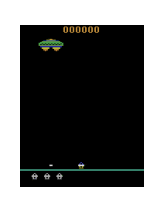

Total Reward:  42.0
--------------------------------------------------
Episode:  5


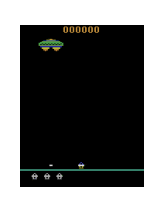

Total Reward:  105.0
--------------------------------------------------
Discrete(7)


In [39]:

from IPython.display import Image

for i in range(NUM_EPISODES):
    observation, info = env.reset()
    frames = []
    obs, rew = [], []
    curr_state = [np.zeros(SIZE, dtype=np.uint8) for i in range(WINDOW_SIZE)]
    total_reward = 0
    epMem.start_episode()
    for t in range(200):
        frames.append(env.render())
        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        prev_state = curr_state.copy()
        curr_state.pop(0)
        curr_state.append(observation.copy())
        obs.append(observation.copy())
        rew.append(reward)
        total_reward += reward
        done = terminated or truncated
        deepMem.remember(prev_state, curr_state.copy(), action, reward, done)
        epMem.remember(prev_state, curr_state.copy(), action, reward, done)
        if done:
            break
    epMem.end_episode()
    
    if(i % 5 == 0):
        save_frames_as_gif(frames)
        print("Episode: ", i)
        display(Image(data=open('gym_animation.gif','rb').read(), format='png'))
        print("Total Reward: ", total_reward)
        print("--------------------------------------------------")
        
env.close()

--------------------------------------------------


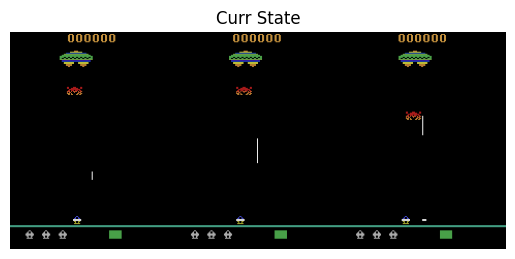

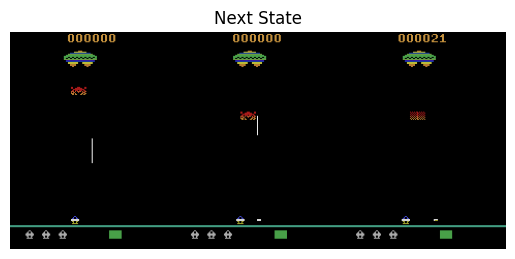

Action:  5
Reward:  21.0
Done:  False
--------------------------------------------------
--------------------------------------------------


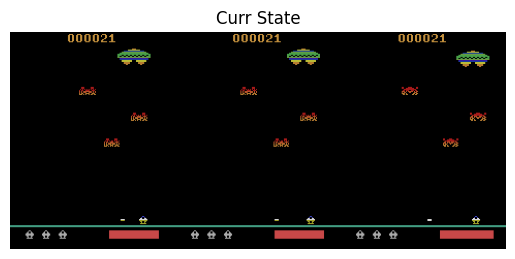

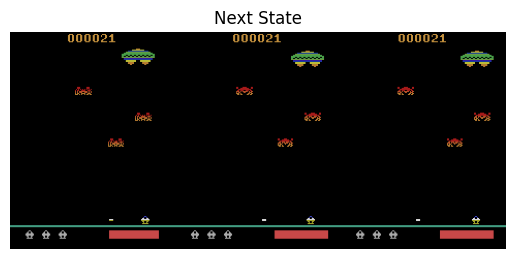

Action:  1
Reward:  0.0
Done:  False
--------------------------------------------------


In [25]:
deepMem.render_sample(deepMem.sample(2))